# fbb skeleton notebook for PUI2017 HW6

In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf

s = json.load( open(os.getenv('PUIDATA')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)
if os.getenv("PUIDATA") is None:
   print ("$PUIDATA to point to set PUIdata dir")

%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  mplDeprecation)


In [2]:
!echo $PUIDATA
!ls

/home/cusp/pak348/PUIdata
building_nrg_instructions.ipynb  PUIDATA


I am using geopanda. that is **not required** for this particular exercise, but geopanda works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code, use PEP8!


** An interesting urban question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

In [3]:
pwd

'/wingrdp/homedirs/pak348/PUI2017_pak348/HW6_pak348'

In [4]:
#Data on energy consumption can be found here for the city of NY 
os.system("curl -O https://raw.githubusercontent.com/praveenashokkumar/PUI2017_pak348/master/HW6_pak348/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
!mv Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv $PUIDATA
#!curl -O https://raw.githubusercontent.com/praveenashokkumar/PUI2017_pak348/master/HW6_pak348/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv

mv: setting attribute `security.selinux' for `security.selinux': Permission denied


In [5]:
eng = pd.read_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
#eng = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

eng.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Reading in the Pluto data for manhattan, which will give me the number of units ber building Manhattan/MNMapPLUTO.shp 
os.system("curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip")
os.system("mv " + "mn_mappluto_16v2.zip " + os.getenv("PUIDATA"))
os.system("unzip " + os.getenv("PUIDATA") + "/mn_mappluto_16v2.zip -d " + os.getenv("PUIDATA") + "/mn_mappluto")

256

In [7]:
man = gp.read_file(os.getenv("PUIDATA") + "/mn_mappluto" + "/MNMapPLUTO.shp")

In [8]:
man.head()


,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,MN,1,201,101,1,1000,02,1,10004,E007,...,10101,None,0.000000e+00,None,1,16V2,0,6306.265838,1.148541e+06,"POLYGON ((973154.7117999941 194614.3315999955,..."
1,MN,9,14,101,9,1013,02,1,10004,L015,...,10101,None,1.000090e+09,12/26/1985,1,16V2,0,686.230174,2.373306e+04,"POLYGON ((980492.3622000068 195423.9451999962,..."
2,MN,15,7501,101,13,2005,02,1,10004,E010,...,10101,None,1.000150e+09,12/29/1998,1,16V2,7,1098.925676,6.753824e+04,"POLYGON ((979999.0820000023 196493.2800000012,..."
3,MN,13,5,101,13,2008,02,1,10004,E010,...,10101,None,0.000000e+00,None,1,16V2,0,709.632239,3.068607e+04,"POLYGON ((980424.4003999978 196274.334800005, ..."
4,MN,1,10,101,5,1018,02,1,10004,E007,...,10101,None,0.000000e+00,None,1,16V2,0,12277.830569,7.550344e+06,"POLYGON ((979561.8711999953 191884.2495999932,..."


In [9]:
eng.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [10]:
man.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord'

In [11]:
# make sure you clean up your data and throw away columns you do not need!
nrg = eng[['BBL', 'Postcode', 'Site EUI(kBtu/ft2)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'DOF Number of Buildings']]
nrg.head()


,BBL,Postcode,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings
0,1.000410e+09,NaN,NaN,918919,NaN,NaN
1,4.021460e+09,11375.0,NaN,NaN,82730.0,1.0
2,2.027620e+09,NaN,NaN,64200,NaN,NaN
3,1.006700e+09,10001.0,NaN,NaN,440360.0,1.0
4,2.048300e+09,NaN,NaN,50000,NaN,NaN


In [12]:
bsize = man[['BBL', 'UnitsRes', 'UnitsTotal', 'YearBuilt']]
bsize.head()

,BBL,UnitsRes,UnitsTotal,YearBuilt
0,1.000010e+09,0,0,1900
1,1.000090e+09,0,0,1987
2,1.000158e+09,500,602,1902
3,1.000130e+09,0,50,1900
4,1.000010e+09,0,0,1900


As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

## exploratory analysis

Scatter plot of Energy Consumption for only those that have numerical values


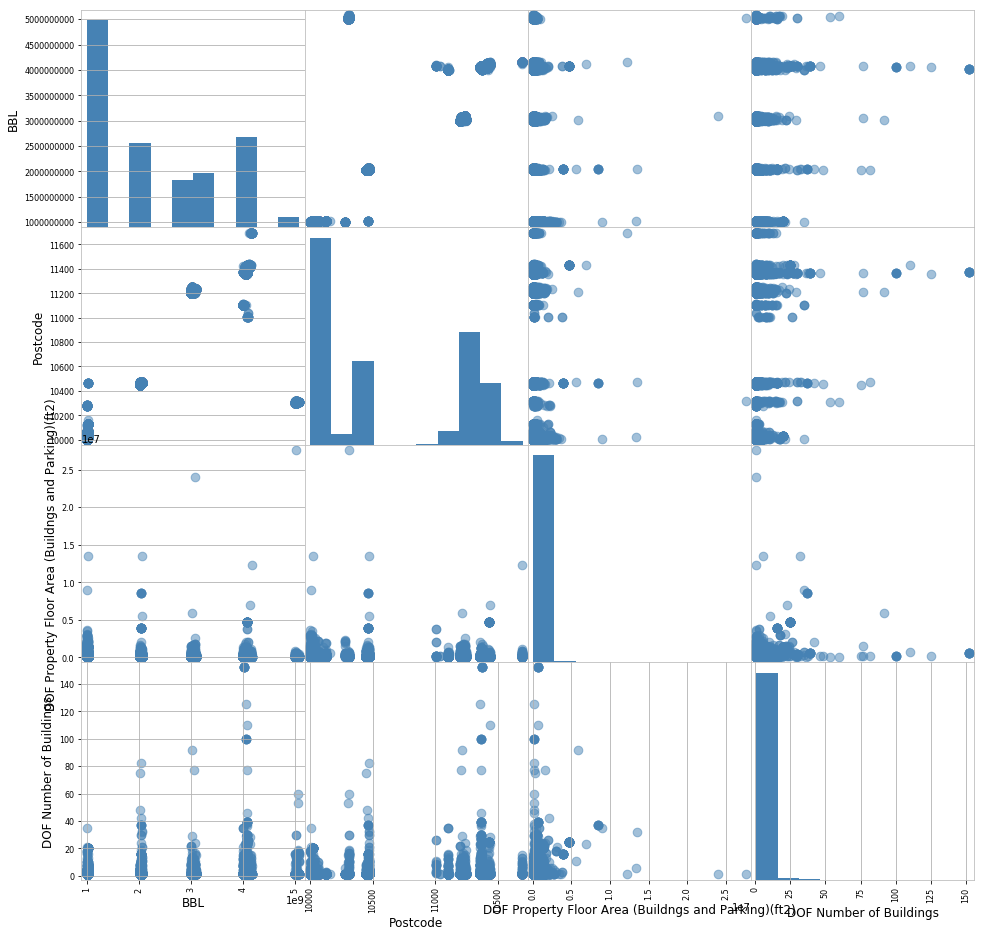

In [13]:
#try make a scatter plot of nrg. Few columns will plot - only those that have numerical values. 
#Pandas will ignore the other ones

from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));
print ("Scatter plot of Energy Consumption for only those that have numerical values")

Figure 1: scatter matrix of all numerical values in the files. This is a very random scatter plot set where there is actually not any correlation we can derive from the plot.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

In [14]:
pd.to_numeric?

In [15]:
nrg.columns

Index(['BBL', 'Postcode', 'Site EUI(kBtu/ft2)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'DOF Number of Buildings'],
      dtype='object')

In [16]:
nrg['BBL']=pd.to_numeric(nrg['BBL'],errors='coerce')
nrg['Postcode']=pd.to_numeric(nrg['Postcode'],errors='coerce')
nrg['Site EUI(kBtu/ft2)']=pd.to_numeric(nrg['Site EUI(kBtu/ft2)'],errors='coerce')
nrg['Reported Property Floor Area (Building(s)) (ft²)']=pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'],errors='coerce')
nrg['DOF Property Floor Area (Buildngs and Parking)(ft2)']=pd.to_numeric(nrg['DOF Property Floor Area (Buildngs and Parking)(ft2)'],errors='coerce')
nrg['DOF Number of Buildings']=pd.to_numeric(nrg['DOF Number of Buildings'],errors='coerce')



/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [17]:
nrg.head()

,BBL,Postcode,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings
0,1.000410e+09,NaN,NaN,918919.0,NaN,NaN
1,4.021460e+09,11375.0,NaN,NaN,82730.0,1.0
2,2.027620e+09,NaN,NaN,64200.0,NaN,NaN
3,1.006700e+09,10001.0,NaN,NaN,440360.0,1.0
4,2.048300e+09,NaN,NaN,50000.0,NaN,NaN


In [18]:
# use pd.to_numeric to convert strings to numeric values, 
##check that your conversion worked: e.g.
#print (nrg['Site EUI(kBtu/ft2)'].astype(float))
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
#bsize.BBL.astype(float)
#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


In [19]:
#How many missing values?
indx = np.isnan(nrg['Site EUI(kBtu/ft2)']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

invalid entries changed to NaN 4623


** MERGE THE DATASETS**
look at the syntax for pandas.merge - this will be incredibly useful to you in all future data problem where you use Pandas and data aggregation is really at the heart of urban science!

TO DO IT WE NEED A COMMON COLUMN: the building id, BBL is in both files. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. 
You can rename the column, create a whole new column 'BBL' in the energy dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!). You can also say pd.merge(..., right_on=BBL, left_on="NYC Borough, Block, and Lot (BBL)'). Always make sure though that the data _type_ is the same:printing the columns the content may look the same but your computer wont know it is the same if it is a different data type (e.g. '1' string is not the same as 1 integer'. '1' == 1 returns False)! both have to be integers, both strings, or whatever, but the same, or you will not be able to merge. 

In [20]:
(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010201.0, 1000410001.0)

In [21]:
bblnrgdata = pd.merge(nrg, bsize, on='BBL').dropna()
bblnrgdata.shape

(4684, 9)

In [22]:
bblnrgdata.head()


,BBL,Postcode,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,UnitsRes,UnitsTotal,YearBuilt
2,1.013110e+09,10022.0,125.4,330000.0,313200.0,1.0,0,56,1977
15,1.007660e+09,10011.0,122.3,59468.0,53168.0,1.0,0,8,1912
16,1.008150e+09,10018.0,117.0,364000.0,364000.0,1.0,0,24,1954
18,1.005050e+09,10013.0,82.1,235370.0,214110.0,1.0,0,24,1926
19,1.021420e+09,10032.0,137.7,64806.0,64816.0,1.0,54,62,1924


In [23]:
bblnrgdata = bblnrgdata[['BBL','Site EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ft²)','UnitsRes','UnitsTotal']]


In [24]:

bblnrgdata = bblnrgdata.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)': 'Floor Area(ft²)'})
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Floor Area(ft²),UnitsRes,UnitsTotal
2,1.013110e+09,125.4,330000.0,0,56
15,1.007660e+09,122.3,59468.0,0,8
16,1.008150e+09,117.0,364000.0,0,24
18,1.005050e+09,82.1,235370.0,0,24
19,1.021420e+09,137.7,64806.0,54,62


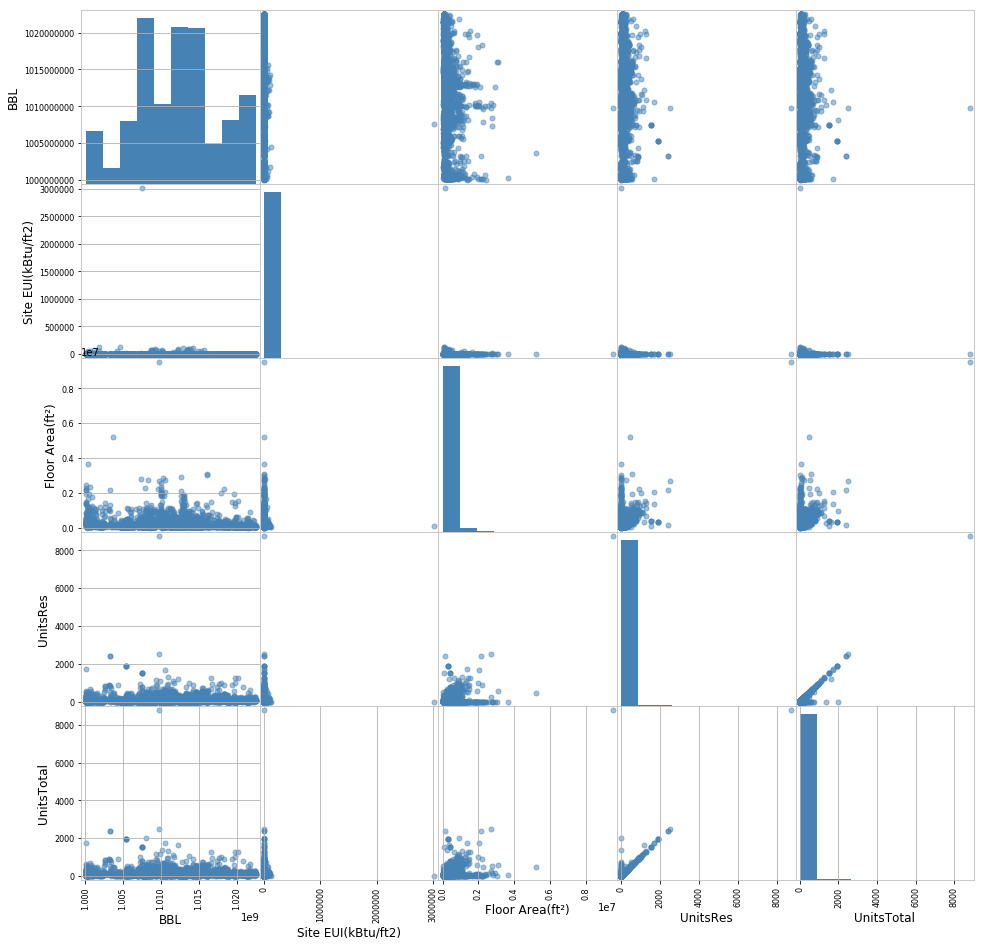

In [25]:
# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=100, figsize=(16, 16));

Figure 2: scatter matix of final dataset. This one is a much better version of the previous scatter plot wherein we can observe minor trends in the data. Like the Total Units and Residential units are proportionsl, which is quite obvious. There is also a minor indication where the energy utilisation per sq.ft is higher for lower number of total units.

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building.  **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [26]:
bblnrgdata['Energy_Total'] = bblnrgdata['Site EUI(kBtu/ft2)'] * bblnrgdata['Floor Area(ft²)']

In [27]:
bblnrgdata.columns

Index(['BBL', 'Site EUI(kBtu/ft2)', 'Floor Area(ft²)', 'UnitsRes',
       'UnitsTotal', 'Energy_Total'],
      dtype='object')

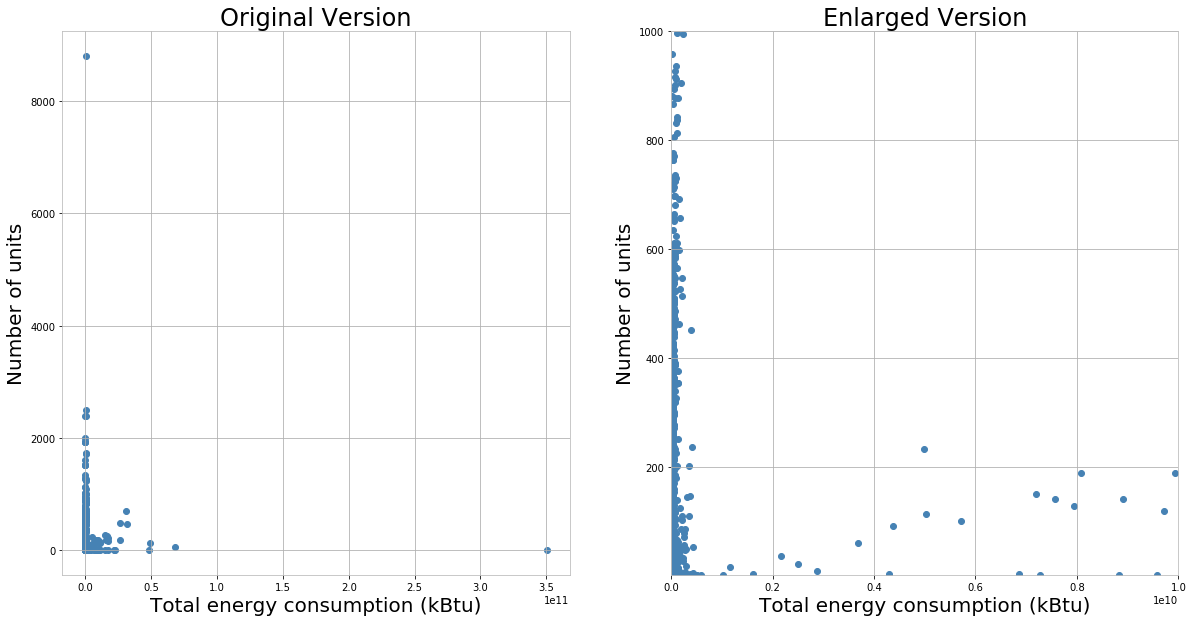

Figure 3. Energy vs Number of Units. When we zoom in we see that fewer no. of units consume more energy at a few places. 


In [28]:
fig = pl.figure(figsize=(20,10))
fig.add_subplot(121)
pl.scatter(bblnrgdata['Energy_Total'], bblnrgdata['UnitsTotal'])
pl.xlabel('Total energy consumption (kBtu)', fontsize=20)
pl.ylabel('Number of units', fontsize=20)
pl.title('Original Version', fontsize = 24)

fig.add_subplot(122)
pl.scatter(bblnrgdata['Energy_Total'], bblnrgdata['UnitsTotal'])
pl.xlabel('Total energy consumption (kBtu)', fontsize=20)
pl.ylabel('Number of units', fontsize=20)
pl.title('Enlarged Version', fontsize = 24)
pl.xlim(1000,1e10)
pl.ylim(1,1000)

pl.show()
print ("Figure 3. Energy vs Number of Units. When we zoom in we see that fewer no. of units consume more energy at a few places. ")

** IMPORTANT NOTE ABOUT LOGS AND LOG PLOTS **
in class we talked about logs when we talked about likelihood: often we prefer working with the log(likelihood) instead of the likelihood, and since all problems involving likelihood are about maximization (find the maximum likelihood to find the best fit parameters) and the log is a MONOTONIC function (log(x) grows when x grows, and gets smaller when x gets smaller) the maximum of the likelihood of a model with be in the same place as the maximum of the log(likelihood). 

Another great thing about logarithm: **when the points in a plot all look scrunched against the axis **
**try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

This will compress the high  x and high  y values, and expand the small x and small y values. 



NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. You can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000] - see below.

Also I removed the buildings with several thousand units. Points like that at the edge of my range would have a lot of "LEVERAGE", however they are not spurious entries like the 0, which I believe are missing values, or perhaps abandoned lots. These are good datapoint that I need to throw away functionally for my analysis to work, but that should be stated clearly in your report.


In [29]:
#you may need to change the name of this column under some versions of pandas
#(ft²) may throw an error due to the funny character depending on encoding
bblnrgdata['Reported Property Floor Area (Building(s))'] = bblnrgdata['Floor Area(ft²)']

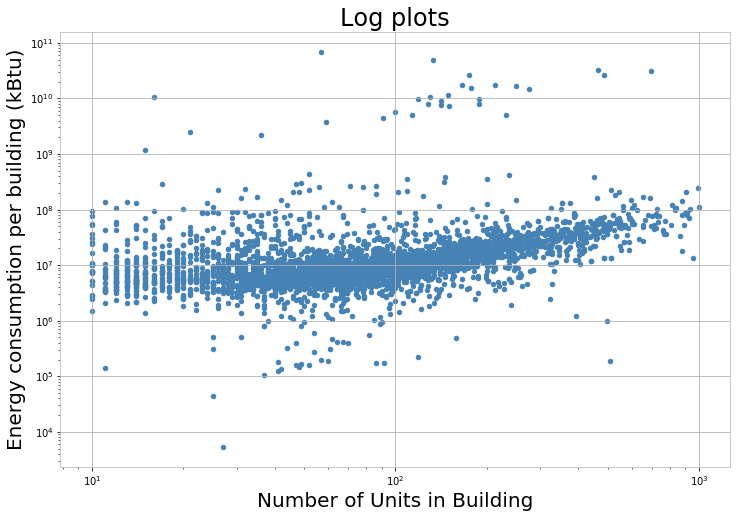

Figure 4. Energy consumption per building vs number of units in building. Looks like an increasing trend in energy consumption with the increase in no. of floors


In [30]:
# I have the energy per sq foot in the data, I need the total energy though
bblnrgdataCut = bblnrgdata[(bblnrgdata['Energy_Total'] > 1000) & (bblnrgdata.UnitsTotal>=10) & 
                           (bblnrgdata.UnitsTotal<1000)]


ax = bblnrgdataCut.plot(kind='scatter', y='Energy_Total', x='UnitsTotal', 
                        marker='o',  figsize=(12, 8), loglog=True)
ax.set_xlabel("Number of Units in Building", fontsize=20)
ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
ax.set_title("Log plots", fontsize = 24)

pl.show()
print ("Figure 4. Energy consumption per building vs number of units in building. " +
       "Looks like an increasing trend in energy consumption with the increase in no. of floors")

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:




1. **Fit a line** to Units vs Energy. The independent variable in this problem should be number of units, but try fit both Unity to energy and energy to unit.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function to calculate the chi square or you can write your own.

    The function is :
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value  model($x_i$) is the prediction, data($x_i$) the observation,
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors?? see next point)
    
4. *Assume Poisson statistics* for the errors on the *independent variable*. Poisson statistics means your uncertainty is the square root of your measurement. I wrote down the formula for the errors. Please explain why I wrote it as I did.

5. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

6. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * log(Likelihood_Model1 / Likelihood_Model2) 

    or equivalently
        
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2) 
    
    where Model1 is the _least complex_ (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels. (Model1.llf)
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferable to Model2. The LR is chi^2 distributed with number of degrees of freedom $N_{DOF}$ = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



In [35]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)
# Make sure your model for the quadratic fit looks right: dont just join the points, you need to sort them first!

In [36]:
# my OLS summary. 
# Yours may be somewhat different depending on how you cut the data

In [31]:
# OLS Modelling
x=bblnrgdataCut.UnitsTotal
y=bblnrgdataCut.Energy_Total
X = sm.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires 
linmodel.summary()                                             # where x or y is NaN

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Energy_Total   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     801.2
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          8.76e-161
Time:                        23:04:09   Log-Likelihood:                -2322.6
No. Observations:                3990   AIC:                             4649.
Df Residuals:                    3988   BIC:                             4662.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1070      0.034    182.067      0.000         6.041     6.173
UnitsTotal     0.4910      0.017     28.306      0.000         0.457     0.525
==============================================================================
Omnibus:                     2193.535   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48111.523
Skew:                           2.157   Prob(JB):                         0.00
Kurtosis:                      19.456   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## choose  which is your DEPENDENT and which is your INDEPENDENT variable. 
which is the "logical" IV: what are we assuming depends on what? energy on size of building or building on size of energy... discuss this but also test both fits, energy vs size and size vs energy. how can you compare these models? 


Figure 5. Energy consumption per building vs number of units in building. Fitting a OLS line in this data.


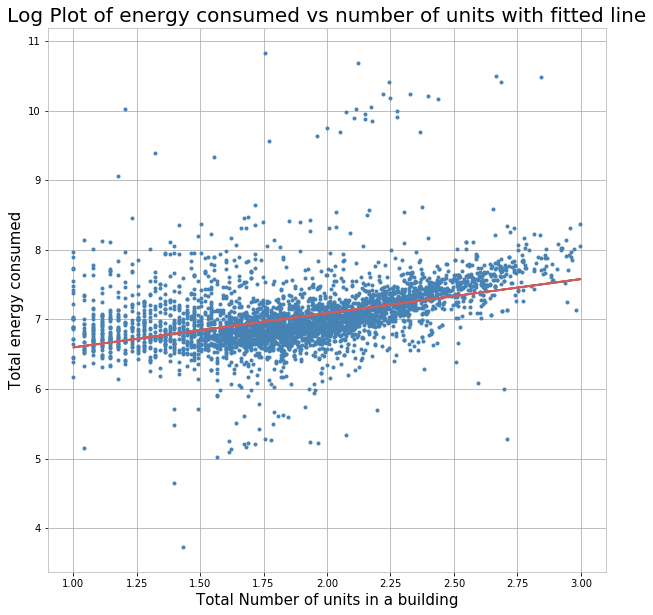

In [32]:

pl.figure(figsize=(10,10))
pl.plot(np.log10(x),np.log10(y),'.')

pl.plot(np.log10(x),linmodel.predict())

pl.xlabel('Total Number of units in a building',fontsize=15)
pl.ylabel('Total energy consumed',fontsize=15)
pl.title('Log Plot of energy consumed vs number of units with fitted line',fontsize=20)
print ("Figure 5. Energy consumption per building vs number of units in building. " +
       "Fitting a OLS line in this data.")


In [33]:
# Fit a line to Energy vs Units.
x=bblnrgdataCut.UnitsTotal
y=bblnrgdataCut.Energy_Total
X = sm.add_constant(np.log10(x))
linmodel2 = sm.OLS(np.log10(x), X,missing='drop').fit()
linmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.078e+32
Date:                Mon, 23 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:04:09   Log-Likelihood:             1.3074e+05
No. Observations:                3990   AIC:                        -2.615e+05
Df Residuals:                    3988   BIC:                        -2.615e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -2.026e-15    1.1e-16    -18.383      0.000     -2.24e-15 -1.81e-15
UnitsTotal     1.0000    5.7e-17   1.75e+16      0.000         1.000     1.000
==============================================================================
Omnibus:                        4.959   Durbin-Watson:                   0.253
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                5.555
Skew:                          -0.002   Prob(JB):                       0.0622
Kurtosis:                       3.183   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Figure 6. Number of units in building vs energy consumption per building.Fitting a OLS line in this data.


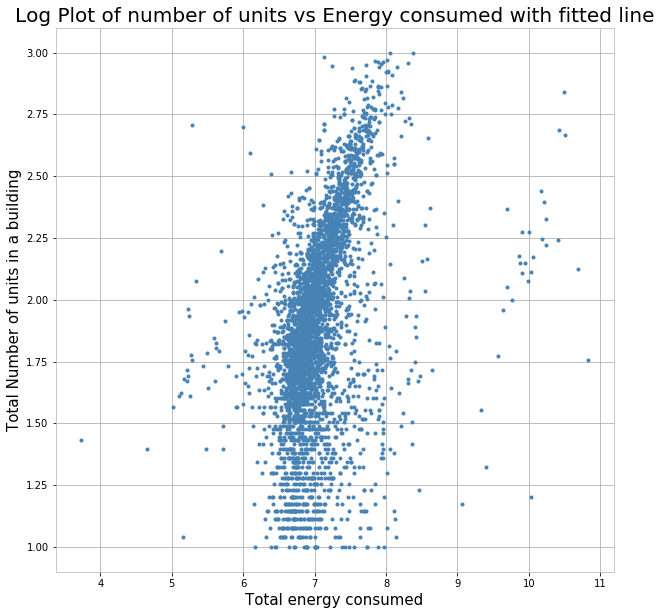

In [42]:
pl.figure(figsize=(10,10))

pl.plot(np.log10(bblnrgdataCut.Energy_Total),np.log10(bblnrgdataCut.UnitsTotal),'.')


pl.xlabel('Total energy consumed',fontsize=15)
pl.ylabel('Total Number of units in a building',fontsize=15)
pl.title('Log Plot of number of units vs Energy consumed with fitted line',fontsize=20)
print ("Figure 6. Number of units in building vs energy consumption per building." +
       "Fitting a OLS line in this data.")

remember your captions etc etc

In [43]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [44]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#Below I am writing out some uncertainties - please explain the functional form that I used.
#errors on the measured quantities


errorsnrg = np.sqrt((bblnrgdataCut['Reported Property Floor Area'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

#These errors need to be propagated properly through the log


KeyError: 'Reported Property Floor Area'

propagation of errors on the log:https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [ ]:
errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.nrg / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

In [ ]:
print ("LR : ", -2 * (-linemodel.llf - (-curvemodel.llf)))
print ("LR from statsmodels:", ...)

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

In [ ]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

In [ ]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)